## OBJECTIVE : 

### Prepare classification model for classifying comments into various categories : toxic, severe_toxic, obscene, threat, insult, identity_hate

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1


In [72]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, AlphaDropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Nadam
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [5]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [6]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")

In [8]:
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "vectors_complex.csv"), encoding="utf-8")

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0,0,0,0,0,...,2,2058,16,15,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,697,9,4,91,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,218,571,76,302,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,17,1,680,2996,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2140,677,371,2,0,0,0,0,0,0


In [11]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values

In [12]:
X.shape, y.shape

((159356, 100), (159356, 6))

In [13]:
X

array([[   0,    0,    0, ..., 2058,   16,   15],
       [   0,    0,    0, ...,    9,    4,   91],
       [   0,    0,    0, ...,  571,   76,  302],
       ...,
       [   0,    0,    0, ..., 2029, 9403, 2902],
       [   0,    0,    0, ...,  189,   18,   27],
       [   0,    0,    0, ...,  206,   30,  958]])

In [14]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [16]:
word_ind_dict = tokenizer.word_index

In [17]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [19]:
num_words

20000

In [20]:
len(word_ind_dict)

151081

In [21]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [22]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [23]:
embed_matrix.shape

(20000, 100)

In [24]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 20000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [25]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(20000, 100, 100)

In [26]:
def create_cnn_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.40)(x)
    x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_initializer="he_normal")(x)
#     x = AlphaDropout(0.45)(x)
    output = Dense(len(CLASSES), activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [58]:
def create_lstm_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = LSTM(15, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [115]:
def create_bidirectional_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Bidirectional(LSTM(15, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
#     x = Bidirectional(LSTM(15, dropout=0.4, recurrent_dropout=0.4))(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [116]:
model = create_bidirectional_model()

In [117]:
model.get_config()

{'name': 'model_7',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_9'},
   'name': 'input_9',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 20000,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_9', 0, 0, {}]]]},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional_3',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'LSTM',
     'config': {'name': 'lstm_7',
      'tra

In [118]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
  metrics=['accuracy']
)

In [119]:
history = model.fit(
  X,
  y,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Train on 127484 samples, validate on 31872 samples
Epoch 1/10
127484/127484 [==============================] - 11s 86us/sample - loss: 0.1046 - accuracy: 0.9691 - val_loss: 0.0668 - val_accuracy: 0.9770
Epoch 2/10
127484/127484 [==============================] - 9s 72us/sample - loss: 0.0636 - accuracy: 0.9783 - val_loss: 0.0609 - val_accuracy: 0.9785
Epoch 3/10
127484/127484 [==============================] - 9s 73us/sample - loss: 0.0572 - accuracy: 0.9796 - val_loss: 0.0579 - val_accuracy: 0.9795
Epoch 4/10
127484/127484 [==============================] - 9s 73us/sample - loss: 0.0541 - accuracy: 0.9805 - val_loss: 0.0549 - val_accuracy: 0.9803
Epoch 5/10
127484/127484 [==============================] - 9s 73us/sample - loss: 0.0517 - accuracy: 0.9812 - val_loss: 0.0533 - val_accuracy: 0.9809
Epoch 6/10
127484/127484 [==============================] - 9s 73us/sample - loss: 0.0500 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9812
Epoch 7/10
127484/127484 [================

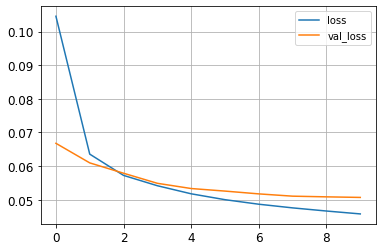

In [120]:
# plot some data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

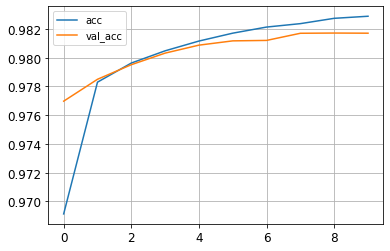

In [121]:
# accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()

In [122]:
# plot the mean AUC over each label
p = model.predict(X)
p = np.where(p > 0.5, 1, 0)
aucs = []
for j in range(6):
    auc = roc_auc_score(y[:,j], p[:,j])
    aucs.append(auc)
print("MEAN auc : ", np.mean(aucs))

MEAN auc :  0.7293324880179838


In [123]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    tn, fp, fn, tp = confusion_matrix(y[:,i], p[:,i]).ravel()
    print("True neg : ", tn)
    print("False pos : ", fp)
    print("False neg : ", fn)
    print("True pos : ", tp)
    print()

For class :  toxic
True neg :  142544
False pos :  1519
False neg :  4423
True pos :  10870

For class :  severe_toxic
True neg :  157464
False pos :  297
False neg :  1150
True pos :  445

For class :  obscene
True neg :  149879
False pos :  1028
False neg :  1913
True pos :  6536

For class :  threat
True neg :  158876
False pos :  2
False neg :  470
True pos :  8

For class :  insult
True neg :  149913
False pos :  1566
False neg :  2681
True pos :  5196

For class :  identity_hate
True neg :  157758
False pos :  193
False neg :  923
True pos :  482



In [124]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    print(classification_report(y[:,i], p[:,i]))
    print()

For class :  toxic
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    144063
           1       0.88      0.71      0.79     15293

    accuracy                           0.96    159356
   macro avg       0.92      0.85      0.88    159356
weighted avg       0.96      0.96      0.96    159356


For class :  severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    157761
           1       0.60      0.28      0.38      1595

    accuracy                           0.99    159356
   macro avg       0.80      0.64      0.69    159356
weighted avg       0.99      0.99      0.99    159356


For class :  obscene
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    150907
           1       0.86      0.77      0.82      8449

    accuracy                           0.98    159356
   macro avg       0.93      0.88      0.90    159356
weight

In [125]:
for i in range(len(CLASSES)):
    print("ROC for CLASS : {} is {}.".format(CLASSES[i], roc_auc_score(y[:, i], p[:, i])))

ROC for CLASS : toxic is 0.8501193564661658.
ROC for CLASS : severe_toxic is 0.6385571353230857.
ROC for CLASS : obscene is 0.8833852649638715.
ROC for CLASS : threat is 0.5083619066991799.
ROC for CLASS : insult is 0.8246519645104651.
ROC for CLASS : identity_hate is 0.6709193001451349.


In [126]:
for i in range(len(CLASSES)):
    print("Precision for CLASS : {} is {}.".format(CLASSES[i], precision_score(y[:, i], p[:, i])))

Precision for CLASS : toxic is 0.8773912341593348.
Precision for CLASS : severe_toxic is 0.5997304582210242.
Precision for CLASS : obscene is 0.86409307244844.
Precision for CLASS : threat is 0.8.
Precision for CLASS : insult is 0.7684117125110914.
Precision for CLASS : identity_hate is 0.7140740740740741.


In [127]:
for i in range(len(CLASSES)):
    print("Recall for CLASS : {} is {}.".format(CLASSES[i], recall_score(y[:, i], p[:, i])))

Recall for CLASS : toxic is 0.7107827110442686.
Recall for CLASS : severe_toxic is 0.27899686520376177.
Recall for CLASS : obscene is 0.773582672505622.
Recall for CLASS : threat is 0.016736401673640166.
Recall for CLASS : insult is 0.6596419956836359.
Recall for CLASS : identity_hate is 0.34306049822064055.


In [128]:
for i in range(len(CLASSES)):
    print("Accuracy for CLASS : {} is {}.".format(CLASSES[i], accuracy_score(y[:, i], p[:, i])))

Accuracy for CLASS : toxic is 0.9627124174803584.
Accuracy for CLASS : severe_toxic is 0.990919701799744.
Accuracy for CLASS : obscene is 0.9815444664775722.
Accuracy for CLASS : threat is 0.9970380782650167.
Accuracy for CLASS : insult is 0.9733489796430633.
Accuracy for CLASS : identity_hate is 0.9929968121689802.
